In [1]:
#Import packages
import numpy as np
from numpy import argmax
import pyspark.sql.functions as F
import snowflake.connector
import pandas as pd
import spacy
#from sparknlp.base import Finisher, DocumentAssembler
#from sparknlp.annotator import  Normalizer, LemmatizerModel, StopWordsCleaner, Tokenizer
#from pyspark.ml import Pipeline
#from pyspark.ml.feature import CountVectorizer, VectorAssembler, HashingTF, IDF, Tokenizer
#from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from scipy import sparse
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, confusion_matrix, plot_confusion_matrix, \
                            roc_curve, auc, classification_report, precision_recall_curve
import matplotlib.pyplot as plt
import imblearn
from autocorrect import Speller

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1602781820330_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
#SPARK connection info
sfOptions = {
  'sfURL' : 'powerreviews.snowflakecomputing.com',
  'sfAccount' : 'powerreviews',
  'sfUser' : 'APP_SPARK_PROD',
  'sfPassword' : '>6txhcQ*7&^Qrq`j',
  'sfDatabase' : 'ANALYTICS_PROD',
  'sfSchema' : 'ANALYTICS',
  'sfWarehouse' : 'LOWER_ENV_WAREHOUSE'
}
SNOWFLAKE_SOURCE_NAME = "net.snowflake.spark.snowflake"

#PYTHON connection info
conn = snowflake.connector.connect(
    account='powerreviews',
    database='analytics_prod',
    warehouse='LOWER_ENV_WAREHOUSE',
    user='APP_SPARK_PROD',
    password='>6txhcQ*7&^Qrq`j'
    )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
#Use review data set to get observation codes bc they are already comma separated and less joins to perform
#Still need observation set though to get observation created date
#This is bc review could be from ages ago but we could have imported recently and moderated it
#Want to make sure we include as many observation labels as possible for most accurate model



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [28]:
query = "select distinct r.ugc_id, r.created_date, r.review_headline, \
r.review_comments, r.review_rating, r.reviewer_nickname, r.locale, r.observations, \
ADD IN CASE WHEN HERE \
from analytics.review as r \
left join cdm.observation as o \
on r.ugc_id = o.ugc_id \
where contains(r.observations, 'PM') \
and r.locale in ('en_US','en_GB','en_CA') \
and o.created_date > '2020-09-23'  \
limit 100"

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [29]:
#Careful not to get CNR for NR
#CNR, NR, PM - contains(r.observations, ',NR,')
#NR, PM - substring(r.observations, 1, 2) = 'NR'
#CNR, PM - DONT WANT
#Careful not to get SSC for SC
#PM, SC - 
#PM, SSC - DONT WANT
#PM, SC, SSC
#18 labels total - not including PM (doesn't yet include NOLABEL label - 19 labels with that)
query_testing = "select distinct r.ugc_id, r.created_date, r.review_headline, \
r.review_comments, r.review_rating, r.reviewer_nickname, r.reviewer_location, r.observations, \
case when contains(r.observations, 'PM') then 1 else 0 end as PM, \
case when (contains(r.observations, ',NR,') or substring(r.observations, 1, 2) = 'NR')  then 1 else 0 end as NR \
from analytics.review as r \
left join cdm.observation as o \
on r.ugc_id = o.ugc_id \
where contains(r.observations, 'PM') \
and (contains(r.observations, ',NR,') or substring(r.observations, 1, 2) = 'NR') \
and r.locale in ('en_US','en_GB','en_CA') \
and o.created_date > '2018-10-01' "

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [30]:
#pd.set_option('display.max_colwidth', -1)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
reviews = pd.read_sql(query_testing, conn)
reviews.head(100)
#reviews.info()

#PULLING IN ALL REVIEWS SINCE '2018-10-01' (64,908,446) TAKES ~15 MINS
#PULLING IN ALL REVIEWS SINCE '2020-01-01' (30,174,364) TAKES ~15 MINS (Not any shorter?)
#PULLING IN ALL REVIEWS SINCE '2018-10-01' with NR label only (510,253) TAKES ~few MINS 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

       UGC_ID        CREATED_DATE  \
0   135665649 2017-12-22 17:01:41   
1   136059039 2017-12-29 05:23:20   
2   136087337 2017-12-29 15:33:54   
3   136061518 2017-12-29 06:34:32   
4   135666042 2017-12-22 17:05:51   
..        ...                 ...   
95  253207877 2019-09-17 11:32:33   
96  253208366 2019-09-17 11:44:21   
97  253207441 2019-09-17 11:24:07   
98  253208213 2019-09-17 11:42:00   
99  253207935 2019-09-17 11:35:05   

                                    REVIEW_HEADLINE  \
0   No!                                               
1   Would buy                                         
2   No                                                
3   Worst Customer Service Ever!!!                    
4   Not sure if the delivery service is trustworthy   
..                                              ...   
95  Don't us online                                   
96  Too much packaging                                
97  NEVER RECEIVED                                    
98  E

In [31]:
reviews.info()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512212 entries, 0 to 512211
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   UGC_ID             512212 non-null  int64         
 1   CREATED_DATE       512212 non-null  datetime64[ns]
 2   REVIEW_HEADLINE    511745 non-null  object        
 3   REVIEW_COMMENTS    511255 non-null  object        
 4   REVIEW_RATING      511972 non-null  float64       
 5   REVIEWER_NICKNAME  511967 non-null  object        
 6   REVIEWER_LOCATION  511972 non-null  object        
 7   OBSERVATIONS       512212 non-null  object        
 8   PM                 512212 non-null  int64         
 9   NR                 512212 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 39.1+ MB

In [32]:
query_testing_2 = "select distinct r.ugc_id, r.created_date, r.review_headline, \
r.review_comments, r.review_rating, r.reviewer_nickname, r.reviewer_location, r.observations, \
case when contains(r.observations, 'PM') then 1 else 0 end as PM, \
case when (contains(r.observations, ',NR,') or substring(r.observations, 1, 2) = 'NR')  then 1 else 0 end as NR \
from analytics.review as r \
left join cdm.observation as o \
on r.ugc_id = o.ugc_id \
where contains(r.observations, 'PM') \
and not contains(r.observations, ',NR,') and substring(r.observations, 1, 2) != 'NR' \
and r.locale in ('en_US','en_GB','en_CA') \
and o.created_date > '2018-10-01' \
limit 500000"

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [33]:
reviews_2 = pd.read_sql(query_testing_2, conn)
reviews_2.head(100)
reviews_2.info()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   UGC_ID             500000 non-null  int64         
 1   CREATED_DATE       500000 non-null  datetime64[ns]
 2   REVIEW_HEADLINE    499968 non-null  object        
 3   REVIEW_COMMENTS    499992 non-null  object        
 4   REVIEW_RATING      499997 non-null  float64       
 5   REVIEWER_NICKNAME  499993 non-null  object        
 6   REVIEWER_LOCATION  499993 non-null  object        
 7   OBSERVATIONS       500000 non-null  object        
 8   PM                 500000 non-null  int64         
 9   NR                 500000 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 38.1+ MB

In [34]:
reviews_2['NR'].sum(axis=0)
#reviews_2[reviews_2['NR']==1]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0

In [35]:
reviews = pd.concat([reviews, reviews_2], axis=0)
reviews

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

           UGC_ID        CREATED_DATE  \
0       135665649 2017-12-22 17:01:41   
1       136059039 2017-12-29 05:23:20   
2       136087337 2017-12-29 15:33:54   
3       136061518 2017-12-29 06:34:32   
4       135666042 2017-12-22 17:05:51   
...           ...                 ...   
499995  219116344 2018-12-09 22:12:08   
499996  226464424 2012-10-17 00:00:00   
499997  226465165 2012-12-13 00:00:00   
499998  226468782 2013-12-06 00:00:00   
499999  226470924 2013-12-11 00:00:00   

                                                         REVIEW_HEADLINE  \
0       No!                                                                
1       Would buy                                                          
2       No                                                                 
3       Worst Customer Service Ever!!!                                     
4       Not sure if the delivery service is trustworthy                    
...                                                

In [36]:
reviews['NR'].sum(axis=0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

512212

In [37]:
reviews.info()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1012212 entries, 0 to 499999
Data columns (total 10 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   UGC_ID             1012212 non-null  int64         
 1   CREATED_DATE       1012212 non-null  datetime64[ns]
 2   REVIEW_HEADLINE    1011713 non-null  object        
 3   REVIEW_COMMENTS    1011247 non-null  object        
 4   REVIEW_RATING      1011969 non-null  float64       
 5   REVIEWER_NICKNAME  1011960 non-null  object        
 6   REVIEWER_LOCATION  1011965 non-null  object        
 7   OBSERVATIONS       1012212 non-null  object        
 8   PM                 1012212 non-null  int64         
 9   NR                 1012212 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 84.9+ MB

In [38]:
#reviews.loc[reviews['REVIEWER_LOCATION'] == 'US', 'REVIEWER_LOCATION'] = 'USA'

#reviews['REVIEWER_LOCATION'].head(500)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [39]:
#Use set_option so text doesn't truncate
#pd.set_option('display.max_colwidth', -1)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
#reviews['LABEL_SUM']= reviews.iloc[:, -18:-1].sum(axis=1)
#reviews

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [40]:
#LOOK AT OTHER LABELS - IF NONE THEN ADD NOLABEL = 1
#df['new column name'] = df['column name'].apply(lambda x: 'value if condition is met' if x condition else 'value if condition is not met')
#reviews['NOLABEL'] = reviews['LABEL_SUM'].apply(lambda x: int(1) if x==0 else int(0))


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [41]:
#reviews2 = reviews.drop(['LABEL_SUM'], axis=1)
#reviews2

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [42]:
#reviews = reviews2
#reviews

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [43]:
reviews.dtypes

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

UGC_ID               int64         
CREATED_DATE         datetime64[ns]
REVIEW_HEADLINE      object        
REVIEW_COMMENTS      object        
REVIEW_RATING        float64       
REVIEWER_NICKNAME    object        
REVIEWER_LOCATION    object        
OBSERVATIONS         object        
PM                   int64         
NR                   int64         
dtype: object

In [44]:
#reviews['ALL_TEXT'] = 'headline ' + reviews['REVIEW_HEADLINE'] + ' comment ' + reviews['REVIEW_COMMENTS'] + \
#        ' nickname ' + reviews['REVIEWER_NICKNAME'] + ' location ' + reviews['REVIEWER_LOCATION']
reviews['ALL_TEXT'] = 'headline ' + reviews['REVIEW_HEADLINE'] + ' comment ' + reviews['REVIEW_COMMENTS']
#Use set_option so text doesn't truncate
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
reviews.head(100)

#reviews.dtypes

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

       UGC_ID        CREATED_DATE  \
0   135665649 2017-12-22 17:01:41   
1   136059039 2017-12-29 05:23:20   
2   136087337 2017-12-29 15:33:54   
3   136061518 2017-12-29 06:34:32   
4   135666042 2017-12-22 17:05:51   
..        ...                 ...   
95  253207877 2019-09-17 11:32:33   
96  253208366 2019-09-17 11:44:21   
97  253207441 2019-09-17 11:24:07   
98  253208213 2019-09-17 11:42:00   
99  253207935 2019-09-17 11:35:05   

                                    REVIEW_HEADLINE  \
0   No!                                               
1   Would buy                                         
2   No                                                
3   Worst Customer Service Ever!!!                    
4   Not sure if the delivery service is trustworthy   
..                                              ...   
95  Don't us online                                   
96  Too much packaging                                
97  NEVER RECEIVED                                    
98  E

In [45]:
from random import sample 
reviews = reviews.sample(n=200000, random_state=1)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [46]:
reviews.info()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 122261 to 402338
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   UGC_ID             200000 non-null  int64         
 1   CREATED_DATE       200000 non-null  datetime64[ns]
 2   REVIEW_HEADLINE    199921 non-null  object        
 3   REVIEW_COMMENTS    199834 non-null  object        
 4   REVIEW_RATING      199963 non-null  float64       
 5   REVIEWER_NICKNAME  199962 non-null  object        
 6   REVIEWER_LOCATION  199963 non-null  object        
 7   OBSERVATIONS       200000 non-null  object        
 8   PM                 200000 non-null  int64         
 9   NR                 200000 non-null  int64         
 10  ALL_TEXT           199792 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(6)
memory usage: 18.3+ MB

In [47]:
#spell=Speller()
#reviews['spell_check'] = reviews['ALL_TEXT'].apply(lambda x: spell(str(x)))


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [48]:
nlp = spacy.load("en_core_web_lg")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [49]:
def spacy_lemmatizer(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [50]:
#Some NaN values causing an error when applying word embedding vector
#reviews['ALL_TEXT'].isnull().values.any()

#Remove NaN values
reviews.dropna(inplace=True)
reviews.info()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199791 entries, 122261 to 402338
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   UGC_ID             199791 non-null  int64         
 1   CREATED_DATE       199791 non-null  datetime64[ns]
 2   REVIEW_HEADLINE    199791 non-null  object        
 3   REVIEW_COMMENTS    199791 non-null  object        
 4   REVIEW_RATING      199791 non-null  float64       
 5   REVIEWER_NICKNAME  199791 non-null  object        
 6   REVIEWER_LOCATION  199791 non-null  object        
 7   OBSERVATIONS       199791 non-null  object        
 8   PM                 199791 non-null  int64         
 9   NR                 199791 non-null  int64         
 10  ALL_TEXT           199791 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(6)
memory usage: 18.3+ MB

In [51]:
#200k reviews
reviews['ALL_TEXT'] = reviews['ALL_TEXT'].apply(lambda x: spacy_lemmatizer(x))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [52]:
reviews

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

           UGC_ID        CREATED_DATE  \
122261  263387544 2019-12-16 12:29:57   
355144  280972714 2020-06-22 11:59:12   
440422  277926745 2020-05-16 14:30:53   
190678  264339633 2020-01-02 06:13:10   
62412   233115933 2014-05-13 00:00:00   
...           ...                 ...   
374201  211460733 2018-10-05 23:30:48   
329652  226283880 2014-01-29 00:00:00   
68953   225298670 2019-01-22 08:42:50   
129254  213419804 2012-10-26 00:00:00   
402338  229801826 2017-10-19 13:00:07   

                                                     REVIEW_HEADLINE  \
122261  N/A                                                            
355144  I returned in store but until now you don't returned my mone   
440422  A yummy treat!                                                 
190678  Unorganised company                                            
62412   cute.                                                          
...       ...                                                          
374

In [54]:
X = reviews[['ALL_TEXT','REVIEW_RATING']]
X

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [55]:
#y = reviews[['NR','PII','PR','CS','DC','CR','FRD','TST','CC','SC','PIM','LC','WEB','FL','SA','URL','CV','US','NOLABEL']]
#y = reviews[['NR','PII','PR','CS','DC','CR','FRD','TST','CC','SC','PIM','LC','WEB','FL','SA','URL','CV','US']]
y = reviews[['NR']]
y

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

        NR
122261  1 
355144  1 
440422  0 
190678  1 
62412   0 
...    .. 
374201  1 
329652  0 
68953   0 
129254  0 
402338  0 

[199791 rows x 1 columns]

In [56]:
y.sum(axis=0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

NR    101112
dtype: int64

In [57]:
#test_size is what % of data goes to test set vs training
#random_state - use so that when comparing models - same data is always going to test and train sets
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=9, stratify = y)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [58]:
print(xtrain)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                                                                                                                                                                                                                                                                                                                                                                                                                                                   ALL_TEXT  \
156833  headline keep blame system do nothing to keep customer happy comment do not recive shoe at all . customer service not willing to help solve problem . unbelievable unprofessional behaviour . unlikely i will use JD again .                                                                                                                                                                                                                                          
129824  headline Shamrocking belt ! comment great belt for this irish guy 

In [59]:
#analyzer : default = word, can also test n_grams
#max_df :  ignore terms that have a document frequency strictly higher than the given threshold
#max_features : set total # of features used
vectorizer = TfidfVectorizer(analyzer = 'word', max_features = 30000, stop_words= 'english', lowercase=True)
#vectors = vectorizer.fit_transform(reviews['ALL_TEXT'].values.astype('U'))
tfidf_vectors_xtrain = vectorizer.fit_transform(xtrain['ALL_TEXT'].apply(lambda x: np.str_(x)))
tfidf_vectors_xtest = vectorizer.transform(xtest['ALL_TEXT'].apply(lambda x: np.str_(x)))
#25 mins for 65 mil rows
#16 mins for 30 mil rows

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [60]:
print(tfidf_vectors_xtrain)
#print(tfidf_vectors_xtest)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  (0, 14458)	0.24862509871634023
  (0, 27982)	0.10757982425172019
  (0, 27721)	0.33698818964138266
  (0, 3691)	0.3860799842479195
  (0, 27773)	0.29663826442583013
  (0, 27495)	0.28089094148052807
  (0, 20626)	0.16262356925763236
  (0, 24507)	0.2573815741064236
  (0, 12747)	0.16396839584448936
  (0, 29096)	0.2626655200056276
  (0, 23489)	0.1273660567954199
  (0, 23767)	0.1508892630865919
  (0, 21542)	0.3058937773083229
  (0, 6288)	0.035412244313595145
  (0, 12469)	0.15718889517947948
  (0, 7353)	0.26792257825431015
  (0, 4016)	0.27743334414192516
  (0, 12624)	0.035412244313595145
  (1, 12264)	0.3092838079504391
  (1, 14218)	0.5360668928753243
  (1, 12034)	0.14648841615649377
  (1, 3732)	0.7679541990056369
  (1, 6288)	0.053681023948152086
  (1, 12624)	0.053681023948152086
  (2, 23470)	0.38456663265706187
  :	:
  (159829, 20748)	0.1231577177716868
  (159829, 6288)	0.03197200475967005
  (159829, 12624)	0.03197200475967005
  (159830, 6646)	0.4224995205856612
  (159830, 21974)	0.359394424285

In [61]:
#Test to see what output looks like - don't use for modeling - dense vectors are memory intensive
#feature_names = vectorizer.get_feature_names()
#dense = tfidf_vectors.todense()
#denselist = dense.tolist()
#df = pd.DataFrame(denselist, columns=feature_names)
#df.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [62]:
#Convert ratings to sparse vector so can join to TF-IDF sparse vector
#ratings_vector_xtrain=sparse.csr_matrix((xtrain['REVIEW_RATING']/5).values).reshape(808202,1)
#print(ratings_vector_xtrain)
#ratings_vector_xtest=sparse.csr_matrix((xtest['REVIEW_RATING']/5).values).reshape(202051,1)
#print(ratings_vector_xtest)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [63]:
#Combine TF-IDF and ratings vectors
#xtrain_final = sparse.hstack([tfidf_vectors_xtrain, ratings_vector_xtrain])
#print(xtrain_final)
#xtest_final = sparse.hstack([tfidf_vectors_xtest, ratings_vector_xtest])
#print(xtest_final)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [64]:
xtrain_final = tfidf_vectors_xtrain
xtest_final = tfidf_vectors_xtest

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [65]:
#max_iter : default =100 but getting error about not converging
lr = LogisticRegression(max_iter=1000, solver = 'lbfgs')
clf = lr


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [66]:
#Support Vector Machine model
#clf = svm.SVC(probability=True)

#Need to change input type of y for training model
#ytrain = ytrain['NR'].ravel()
#ytrain.shape

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [67]:
#Train model
#start 1241 for 50k
clf.fit(xtrain_final, ytrain)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

LogisticRegression(max_iter=1000)
/usr/local/lib64/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)

In [68]:
#ytrain.dtypes
ytrain.sum(axis=0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

NR    80889
dtype: int64

In [69]:
y_pred = clf.predict(xtest_final)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [70]:
plt.clf()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [71]:
%matplotlib inline

In [72]:
#Confusion matrix
#confusion_matrix(ytest, y_pred)
#tn, fp, fn, tp = confusion_matrix(ytest, y_pred).ravel()
#print("TN: {}".format(tn), "FP: {}".format(fp), "FN: {}".format(fn), "TP: {}".format(tp))
plot_confusion_matrix(clf, xtest_final, ytest)
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

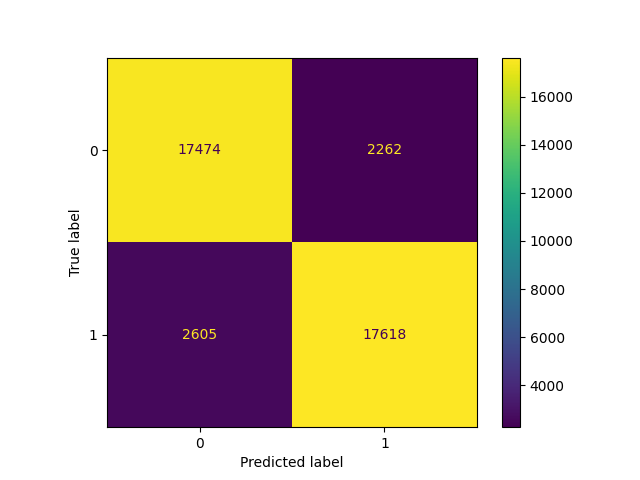

In [73]:
%matplot plt

In [74]:
#Evaluating model performance
#There are inherently mostly NOLABEL so accuracy could be high just bc of those
#Want to make sure that when there is a label besides NOLABEL that it is being accurately predicted


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [75]:
#Model performance metrics
#Assess at individual label level as well as overall

#Accuracy is overall correct predictions - not great measurement tool for imbalanced data
#Precision - TP / TP + FP = spam detection - don't want to mark something as spam (FP) when it isn't
#Recall - TP / TP + FN = sickness - don't want to tell someone they aren't sick (FN) when they are and can spread it
#F1 - balance of precision and recall

#We want to make sure if bomb emoji then it gets marked - even at the expense of marking other things potentially offensive that aren't 
#Important not to have FN - USE RECALL
#Also don't want to be marking a bunch of stuff as offensive when it isn't and making moderation do everything anyway
#Important not to have too many FP - USE PRECISION
#Use F1 for balance between both
print("Accuracy is:  {}" .format(accuracy_score(ytest, y_pred)))
print("Precision is:  {}" .format(precision_score(ytest, y_pred)))
print("Recall is:  {}" .format(recall_score(ytest, y_pred)))
print("F1 Score is:  {}" .format(f1_score(ytest, y_pred)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Accuracy is:  0.878200155159038
Precision is:  0.8862173038229376
Recall is:  0.871186273055432
F1 Score is:  0.8786375084158292

In [76]:
print(classification_report(ytest,y_pred))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

              precision    recall  f1-score   support

           0       0.87      0.89      0.88     19736
           1       0.89      0.87      0.88     20223

    accuracy                           0.88     39959
   macro avg       0.88      0.88      0.88     39959
weighted avg       0.88      0.88      0.88     39959

In [77]:
probs = clf.predict_proba(xtest_final)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(ytest, preds)
roc_auc = auc(fpr, tpr)
print(roc_auc)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.9485129035814912

In [78]:
plt.clf()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [79]:
#ROC CURVE
#Assumes we care about 0 and 1 classification the same - we don't
#We care more about performance of 1 classification - use precision recall curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

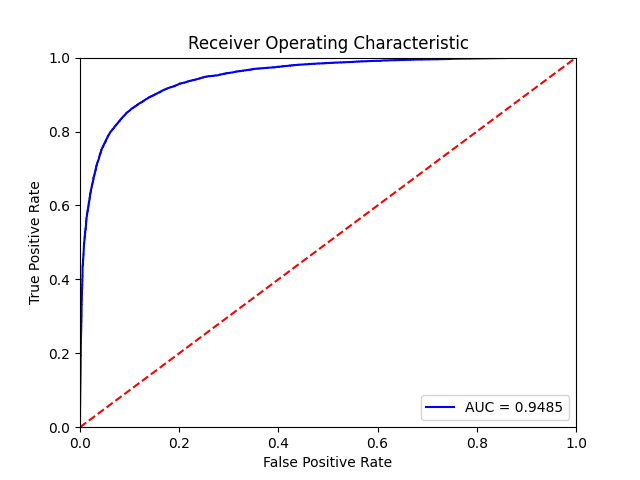

In [80]:
%matplot plt

In [81]:
#Find best threshold (ROC Curve)
#Ideally want tpr = 1 and fpr = 0, so want tpr - fpr as close to 1 as possible
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = threshold[optimal_idx]
opt_tpr = tpr[optimal_idx]
opt_fpr = fpr[optimal_idx]
print("Optimal threshold value:", optimal_threshold)
print("Optimal tpr value:", opt_tpr)
print("Optimal fpr value:", opt_fpr)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Optimal threshold value: 0.5245245644034537
Optimal tpr value: 0.8620382732532266
Optimal fpr value: 0.1041244426428861

In [82]:
t = optimal_threshold
y_pred_new = (preds >= t).astype(int)
#y_pred_new

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [83]:
#Scores with best threshold cutoff
print("Accuracy is:  {}" .format(accuracy_score(ytest, y_pred_new)))
print("Precision is:  {}" .format(precision_score(ytest, y_pred_new)))
print("Recall is:  {}" .format(recall_score(ytest, y_pred_new)))
print("F1 Score is:  {}" .format(f1_score(ytest, y_pred_new)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Accuracy is:  0.8787507194874746
Precision is:  0.8945504926108374
Recall is:  0.8620382732532266
F1 Score is:  0.8779935030596057

In [84]:
len(y_pred_new)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

39959

In [85]:
#PRECISION RECALL CURVE
#Better for what we want to assess which is how well label is assigned (i.e. when it gets a 1 instead of a 0)

precision, recall, pr_threshold = precision_recall_curve(ytest, preds)
auc = auc(recall, precision)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [86]:
plt.clf()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [87]:
plt.title('Precision - Recall Curve')
plt.plot(recall, precision, 'b', label = 'AUC = %0.4f' % auc)
plt.legend(loc = 'lower right')
no_skill = len(ytest[ytest['NR']==1]) / len(ytest)
plt.plot([0, 1], [no_skill, no_skill], 'r--', label='No Skill')
#plt.xlim([0, 1])
#plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

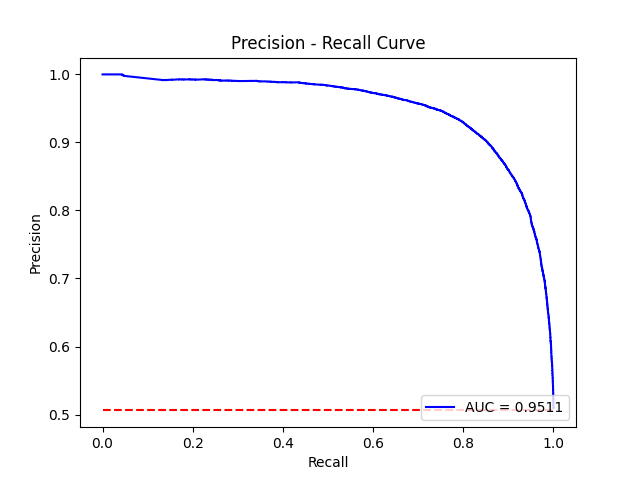

In [88]:
%matplot plt

In [89]:
#Best F1 score optimizes precision recall trade off

fscore = (2 * precision * recall) / (precision + recall)
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (pr_threshold[ix], fscore[ix]))

print('Recall=%f' % recall[ix])
print('Precision=%f' % precision[ix])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Best Threshold=0.442825, F-Score=0.880
Recall=0.892647
Precision=0.867843

In [90]:
plt.clf()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [91]:
plt.hist(preds, bins=10)
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

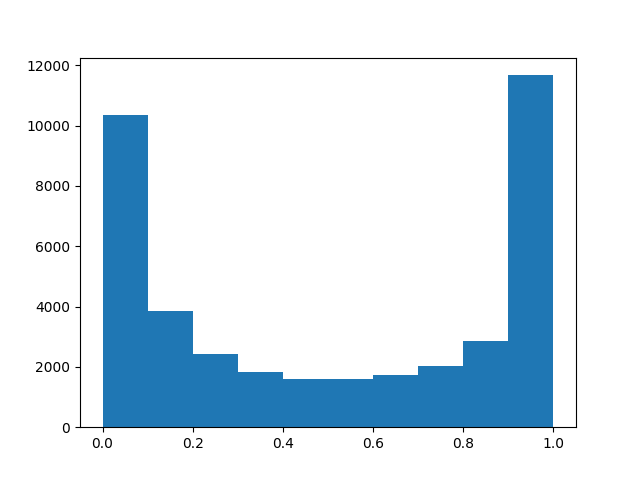

In [92]:
%matplot plt

In [161]:
#importance = clf.coef_
#importance

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [162]:

#feature_names = vectorizer.get_feature_names()
#dense = importance
#denselist = dense.tolist()
#df = pd.DataFrame(denselist, columns=feature_names)
#df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
y_pred_df = pd.DataFrame(data=y_pred, columns = 'y_pred')

In [195]:

results = pd.concat([xtest, ytest], axis=1)
results

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           ALL_TEXT  \
41212   headline A lot of work for ok results comment I had high hopes for this because I love almost all of my Lush products. I don't have a problem with leaving it in for 20 minutes, and it does leave my hair very soft afterwards. I just don't notice any difference at all to my blonde hair. I do bleach my hair though. Maybe it works better for natur

In [196]:
results.reset_index(drop=True, inplace=True)
y_pred_df.reset_index(drop=True, inplace=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [197]:
results = pd.concat([results, y_pred_df], axis = 1)
results

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           ALL_TEXT  \
0       headline A lot of work for ok results comment I had high hopes for this because I love almost all of my Lush products. I don't have a problem with leaving it in for 20 minutes, and it does leave my hair very soft afterwards. I just don't notice any difference at all to my blonde hair. I do bleach my hair though. Maybe it works better for natur

In [199]:
results[results['NR']!=results['y_pred']]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

'0'
Traceback (most recent call last):
  File "/usr/local/lib64/python3.7/site-packages/pandas/core/frame.py", line 2902, in __getitem__
    indexer = self.columns.get_loc(key)
  File "/usr/local/lib64/python3.7/site-packages/pandas/core/indexes/base.py", line 2897, in get_loc
    raise KeyError(key) from err
KeyError: '0'



In [ ]:
results_sparkdf = spark.createDataFrame(results)

In [186]:
sfOptions2 = {
  'sfURL' : 'powerreviews.snowflakecomputing.com',
  'sfAccount' : 'powerreviews',
  'sfUser' : 'APP_SPARK_PROD',
  'sfPassword' : '>6txhcQ*7&^Qrq`j',
  'sfDatabase' : 'ANALYTICS_WORKSHOP',
  'sfSchema' : 'DATA_SCIENCE',
  'sfWarehouse' : 'LOWER_ENV_WAREHOUSE'
}


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [187]:
 
results_sparkdf.write.format(SNOWFLAKE_SOURCE_NAME).options(**sfOptions2) \
    .option("dbtable","MODLABEL_TEST").mode("append").save()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

'DataFrame' object has no attribute 'write'
Traceback (most recent call last):
  File "/usr/local/lib64/python3.7/site-packages/pandas/core/generic.py", line 5139, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'write'



In [198]:
#import pandas
from snowflake.connector.pandas_tools import write_pandas

conn = snowflake.connector.connect(
    account='powerreviews',
    database='analytics_prod',
    warehouse='LOWER_ENV_WAREHOUSE',
    user='APP_SPARK_PROD',
    password='>6txhcQ*7&^Qrq`j'
    )

# Write the data from the DataFrame to the table named "customers".
success, nchunks, nrows, _ = pd.write_pandas(conn, results, 'MODLABEL_TEST')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Missing optional dependency: pandas
Traceback (most recent call last):
  File "/usr/local/lib64/python3.7/site-packages/snowflake/connector/pandas_tools.py", line 143, in <module>
    def pd_writer(table: pandas.io.sql.SQLTable,
  File "/usr/local/lib64/python3.7/site-packages/snowflake/connector/options.py", line 25, in __getattr__
    raise MissingDependencyError('pandas')
snowflake.connector.errors.MissingDependencyError: Missing optional dependency: pandas



In [93]:
#LOGISTIC REGRESSION - solver default=’lbfgs’

#Only comments and headline - not location and nickname
#Single tokens
#data set = 64,908,446
#max_features = 50000
#ERRORS WITH: (but don't see any missing values so not sure, memory issue?)
#Input contains NaN, infinity or a value too large for dtype('float64').

#Only comments and headline - not location and nickname
#Single tokens
#data set = 30 mil
#max_features = 30000
#Best Threshold=0.245491, F-Score=0.457
#Recall=0.445479
#Precision=0.468923

#SEE MODEL RESEARCH DOC FOR REST OF COMPARISON #S

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…